__LOGISTIC REGRESSION ON AIRBNB DATA__

__CAPSTONE PROJECT #1 MACHINE LEARNING APPLICATION__


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

print("Loaded")
airbnb = pd.read_csv('data/dfmergefinal.csv')

Loaded


In [2]:
airbnb.shape

(3340486, 30)

In [3]:
airbnb.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [4]:
#create labels for age groups
airbnb['age'] = pd.cut(airbnb.age,bins=[0,2,10,17,35,65,150],labels=['Toddler','Child','Young Adult','Adult', 
                                                                  'Middle Age','Older Adult'])

In [5]:
airbnb.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [6]:
#drop user_id, data_account_created, timestamp_first_active, and date_first_booking because they don't seem to be 
#my interest. For example, I am not creating models for each user. 
airbnb = airbnb.drop(['user_id', 'date_account_created','timestamp_first_active', 'date_first_booking'], axis=1)

In [7]:
airbnb.shape

(3340486, 26)

In [8]:
airbnb.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,MALE,Middle Age,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,NaN,NaN,NaN,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [9]:
#I don't think it is clear what signup_flow means. So, I will drop this as well
airbnb['signup_flow'].value_counts(dropna=False)

0     2650986
25     263652
12     219121
23     133799
24      69657
8        3225
21         46
Name: signup_flow, dtype: int64

In [10]:
#drop signup_flow
airbnb = airbnb.drop(['signup_flow'], axis=1)

In [11]:
airbnb.shape

(3340486, 25)

In [12]:
airbnb['signup_app'].value_counts(normalize=True, dropna=False)

Web        0.795725
iOS        0.100971
Android    0.077003
Moweb      0.026301
Name: signup_app, dtype: float64

In [13]:
airbnb.signup_app=airbnb['signup_app'].replace(to_replace =["iOS", "Android", "Moweb"], 
                 value ="Mobile")

In [14]:
airbnb['signup_app'].value_counts(normalize=True)

Web       0.795725
Mobile    0.204275
Name: signup_app, dtype: float64

In [15]:
#drop some other columns that are not related

airbnb = airbnb.drop(['lat_destination', 'lng_destination','distance_km', 'destination_km2',
                           'language_levenshtein_distance'], axis=1)

In [16]:
airbnb.shape

(3340486, 20)

In [17]:
airbnb['first_browser'].value_counts(normalize=True, dropna=False)

Chrome                0.306323
Safari                0.223301
NaN                   0.173942
Firefox               0.126786
Mobile Safari         0.083990
IE                    0.073073
Chrome Mobile         0.006146
Android Browser       0.002511
Silk                  0.000892
Opera                 0.000884
Chromium              0.000365
AOL Explorer          0.000298
Apple Mail            0.000277
Mobile Firefox        0.000262
Maxthon               0.000187
Sogou Explorer        0.000134
BlackBerry Browser    0.000134
SiteKiosk             0.000102
Yandex.Browser        0.000097
IceWeasel             0.000074
Iron                  0.000053
Opera Mini            0.000041
IE Mobile             0.000041
CoolNovo              0.000037
TenFourFox            0.000017
SeaMonkey             0.000009
Outlook 2007          0.000006
wOSBrowser            0.000005
Mozilla               0.000004
Pale Moon             0.000004
Googlebot             0.000004
Name: first_browser, dtype: float64

In [18]:
airbnb['first_browser'] = airbnb['first_browser'].replace(to_replace = ['Android Browser', 'BlackBerry Browser',
                                                                             'wOSBrowser', 'Yandex.Browser', 'Opera',
                                                                             'Mozilla', 'Silk'],
                                                                value='Other Browser')

In [19]:
airbnb['first_browser'].value_counts(normalize=True, dropna=False)

Chrome            0.306323
Safari            0.223301
NaN               0.173942
Firefox           0.126786
Mobile Safari     0.083990
IE                0.073073
Chrome Mobile     0.006146
Other Browser     0.004527
Chromium          0.000365
AOL Explorer      0.000298
Apple Mail        0.000277
Mobile Firefox    0.000262
Maxthon           0.000187
Sogou Explorer    0.000134
SiteKiosk         0.000102
IceWeasel         0.000074
Iron              0.000053
Opera Mini        0.000041
IE Mobile         0.000041
CoolNovo          0.000037
TenFourFox        0.000017
SeaMonkey         0.000009
Outlook 2007      0.000006
Googlebot         0.000004
Pale Moon         0.000004
Name: first_browser, dtype: float64

In [20]:
airbnb['first_browser'] = airbnb['first_browser'].replace(to_replace = ['Chrome Mobile', 'Mobile Safari',
                                                                             'IE Mobile', 'Mobile Firefox'],
                                                                value='Mobile')

In [21]:
airbnb['first_browser'].value_counts(normalize=True, dropna=False)

Chrome            0.306323
Safari            0.223301
NaN               0.173942
Firefox           0.126786
Mobile            0.090438
IE                0.073073
Other Browser     0.004527
Chromium          0.000365
AOL Explorer      0.000298
Apple Mail        0.000277
Maxthon           0.000187
Sogou Explorer    0.000134
SiteKiosk         0.000102
IceWeasel         0.000074
Iron              0.000053
Opera Mini        0.000041
CoolNovo          0.000037
TenFourFox        0.000017
SeaMonkey         0.000009
Outlook 2007      0.000006
Pale Moon         0.000004
Googlebot         0.000004
Name: first_browser, dtype: float64

In [22]:
airbnb['first_browser'] = airbnb['first_browser'].replace(to_replace = ['Chromium', 'AOL Explorer', 'Apple Mail', 
                                                                             'Maxthon', 'Sogou Explorer', 'SiteKiosk',
                                                                             'IceWeasel', 'Iron','Opera Mini','CoolNovo',
                                                                             'TenFourFox', 'SeaMonkey', 'Outlook 2007',
                                                                             'Pale Moon', 'Googlebot'],
                                                                value='Other')

In [23]:
airbnb['first_browser'].value_counts(normalize=True, dropna=False)

Chrome           0.306323
Safari           0.223301
NaN              0.173942
Firefox          0.126786
Mobile           0.090438
IE               0.073073
Other Browser    0.004527
Other            0.001608
Name: first_browser, dtype: float64

In [24]:
# I also want to replace other browser with other
airbnb['first_browser'] = airbnb['first_browser'].replace(to_replace = ['Other Browser'],
                                                                value='Other')

In [25]:
airbnb['first_browser'].value_counts(normalize=True, dropna=False)

Chrome     0.306323
Safari     0.223301
NaN        0.173942
Firefox    0.126786
Mobile     0.090438
IE         0.073073
Other      0.006136
Name: first_browser, dtype: float64

In [26]:
airbnb.head()

,gender,age,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,MALE,Middle Age,basic,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,MALE,Middle Age,basic,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,MALE,Middle Age,basic,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,MALE,Middle Age,basic,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,MALE,Middle Age,basic,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [27]:
#drop the language because there could be a correlation between language and country destination
airbnb = airbnb.drop(['language'], axis=1)

In [28]:
airbnb.shape

(3340486, 19)

In [29]:
airbnb.head()

,gender,age,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [30]:
airbnb['signup_method'].value_counts(normalize=True, dropna=False)

basic       0.766506
facebook    0.226921
google      0.006573
Name: signup_method, dtype: float64

In [31]:
airbnb['affiliate_channel'].value_counts(normalize=True, dropna=False)


direct           0.610976
sem-brand        0.168126
sem-non-brand    0.089930
seo              0.048508
api              0.041074
content          0.018038
other            0.012488
remarketing      0.010861
Name: affiliate_channel, dtype: float64

In [32]:
#in affiliate channels, content, other and remarmeting are very close. I will put them all into other
airbnb['affiliate_channel'] = airbnb['affiliate_channel'].replace(to_replace = ['content', 'remarketing'],
                                                                value='other')

In [33]:
airbnb['affiliate_channel'].value_counts(normalize=True, dropna=False)

direct           0.610976
sem-brand        0.168126
sem-non-brand    0.089930
seo              0.048508
other            0.041387
api              0.041074
Name: affiliate_channel, dtype: float64

In [34]:
airbnb['affiliate_provider'].value_counts(normalize=True, dropna=False)

direct                 0.610976
google                 0.315539
other                  0.050280
facebook               0.008536
bing                   0.007424
padmapper              0.002239
yahoo                  0.001631
facebook-open-graph    0.000799
email-marketing        0.000755
vast                   0.000641
naver                  0.000517
gsp                    0.000246
baidu                  0.000192
yandex                 0.000134
daum                   0.000065
meetup                 0.000027
craigslist             0.000001
Name: affiliate_provider, dtype: float64

In [35]:
#As seen above, direct and google are the most common affiliate providers. So, I am going to replace the rest of them
#with other
airbnb['affiliate_provider'] = airbnb['affiliate_provider'].replace(to_replace = ['craigslist', 'meetup', 'daum','yandex',
                                                                             'baidu', 'gsp', 'naver','vast','yahoo',
                                                                             'email-marketing', 'padmapper','bing',
                                                                             'facebook-open-graph', 'facebook'],
                                                                value='other')

In [36]:
airbnb['affiliate_provider'].value_counts(normalize=True, dropna=False)

direct    0.610976
google    0.315539
other     0.073485
Name: affiliate_provider, dtype: float64

In [37]:
airbnb['first_affiliate_tracked'].value_counts(normalize=True, dropna=False)

untracked        0.546922
omg              0.251476
linked           0.176282
tracked-other    0.014404
product          0.007392
marketing        0.002713
local ops        0.000421
NaN              0.000389
Name: first_affiliate_tracked, dtype: float64

In [38]:
#Here, I will change the small values with tracked-other
airbnb['first_affiliate_tracked'] = airbnb['first_affiliate_tracked'].replace(to_replace = ['local ops',
                                                                                                  'marketing', 'product'],
                                                                value='tracked-other')

In [39]:
airbnb['first_affiliate_tracked'].value_counts(normalize=True, dropna=False)

untracked        0.546922
omg              0.251476
linked           0.176282
tracked-other    0.024931
NaN              0.000389
Name: first_affiliate_tracked, dtype: float64

In [40]:
airbnb.head()

,gender,age,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [41]:
airbnb['first_device_type'].value_counts(normalize=True, dropna=False)

Mac Desktop           0.417064
Windows Desktop       0.303728
iPhone                0.107978
Other/Unknown         0.075564
iPad                  0.070686
Android Phone         0.011367
Android Tablet        0.007346
Desktop (Other)       0.006061
SmartPhone (Other)    0.000206
Name: first_device_type, dtype: float64

In [42]:
#Create a single group for smartphones
airbnb['first_device_type'] = airbnb['first_device_type'].replace(to_replace = ['iPhone','Android Phone',
                                                                                     'SmartPhone (Other)'],
                                                                value='Smart Phone')

In [43]:
airbnb['first_device_type'].value_counts(normalize=True, dropna=False)

Mac Desktop        0.417064
Windows Desktop    0.303728
Smart Phone        0.119550
Other/Unknown      0.075564
iPad               0.070686
Android Tablet     0.007346
Desktop (Other)    0.006061
Name: first_device_type, dtype: float64

In [44]:
#Create a single group for tablets
airbnb['first_device_type'] = airbnb['first_device_type'].replace(to_replace = ['iPad','Android Tablet'],
                                                                value='Tablet')

In [45]:
airbnb['first_device_type'].value_counts(normalize=True, dropna=False)

Mac Desktop        0.417064
Windows Desktop    0.303728
Smart Phone        0.119550
Tablet             0.078032
Other/Unknown      0.075564
Desktop (Other)    0.006061
Name: first_device_type, dtype: float64

In [46]:
airbnb.head()

,gender,age,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,action,action_type,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,search_results,click,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,lookup,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [47]:
airbnb['action'].value_counts(normalize=True, dropna=False)

show                                  2.151307e-01
search_results                        9.155315e-02
personalize                           9.108016e-02
index                                 7.955459e-02
ajax_refresh_subtotal                 6.272261e-02
similar_listings                      5.726951e-02
lookup                                3.763644e-02
update                                3.721524e-02
search                                3.275392e-02
social_connections                    2.382288e-02
header_userpic                        1.608898e-02
create                                1.594738e-02
active                                1.563485e-02
track_page_view                       1.358724e-02
dashboard                             1.179709e-02
collections                           1.123609e-02
NaN                                   1.014104e-02
reviews                               9.536636e-03
edit                                  9.018448e-03
calendar_tab_inner2            

In [48]:
airbnb['action_detail'].value_counts(normalize=True, dropna=False)

NaN                              2.330251e-01
view_search_results              1.742884e-01
p3                               9.234345e-02
wishlist_content_update          9.108016e-02
change_trip_characteristics      6.272261e-02
similar_listings                 5.726951e-02
user_profile                     4.073988e-02
update_listing                   2.822733e-02
user_social_connections          2.316819e-02
header_userpic                   1.608898e-02
user_wishlists                   1.399198e-02
message_thread                   1.280442e-02
dashboard                        1.179709e-02
contact_host                     1.134715e-02
message_post                     1.088614e-02
edit_profile                     8.969653e-03
listing_reviews                  7.709956e-03
change_contact_host_dates        7.438139e-03
create_user                      6.730757e-03
confirm_email_link               6.669389e-03
user_profile_content_update      5.131888e-03
login                            4

In [49]:
airbnb['action_detail'].nunique()

112

In [50]:
airbnb['action'].nunique()

280

In [51]:
airbnb['action_type'].value_counts(normalize=True, dropna=False)

view                2.668716e-01
NaN                 2.330251e-01
data                2.119883e-01
click               2.080811e-01
submit              6.618169e-02
message_post        1.088614e-02
booking_request     1.999410e-03
partner_callback    9.663265e-04
booking_response    2.993576e-07
Name: action_type, dtype: float64

In [52]:
#There is little value in action type. I will drop it. In terms of action details and action, I am not going to
#touch them now because I can see some important values could be important for my analysis.
#However, I will be tinking about it while working on other cleaning stuff.

airbnb = airbnb.drop(['action_type'], axis=1)

In [53]:
#similarly, it is not clearly indicated what the differences are between action and action detail.
#However, I feel that action detail is grouped-themes version on action. So, I will drop action as well
airbnb = airbnb.drop(['action'], axis=1)

In [54]:
airbnb.shape

(3340486, 17)

In [55]:
airbnb.head()

,gender,age,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,action_detail,device_type,secs_elapsed,age_bucket,population_in_thousands,year
0,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,Windows Desktop,319.0,NaN,NaN,NaN
1,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,view_search_results,Windows Desktop,67753.0,NaN,NaN,NaN
2,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,Windows Desktop,301.0,NaN,NaN,NaN
3,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,view_search_results,Windows Desktop,22141.0,NaN,NaN,NaN
4,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,Windows Desktop,435.0,NaN,NaN,NaN


In [56]:
airbnb['age_bucket'].value_counts(normalize=True, dropna=False)

NaN    1.0
Name: age_bucket, dtype: float64

In [57]:
#drop age bucket because all values are nan
airbnb = airbnb.drop('age_bucket', axis=1)

In [58]:
airbnb.shape

(3340486, 16)

In [59]:
airbnb['population_in_thousands'].value_counts(normalize=True, dropna=False)

NaN    1.0
Name: population_in_thousands, dtype: float64

In [60]:
#drop population because all values are nan
airbnb = airbnb.drop('population_in_thousands', axis=1)

In [61]:
airbnb.shape

(3340486, 15)

In [62]:
airbnb['year'].value_counts(normalize=True, dropna=False)

NaN    1.0
Name: year, dtype: float64

In [63]:
#drop year because all values are nan
airbnb = airbnb.drop('year', axis=1)

In [64]:
airbnb.shape

(3340486, 14)

In [65]:
airbnb = airbnb[airbnb['country_destination'] != 'NDF']

In [66]:
airbnb.country_destination.value_counts(normalize=True, dropna=False)

US       0.672212
other    0.136360
FR       0.059908
IT       0.039769
ES       0.027520
GB       0.026237
CA       0.012612
DE       0.009630
NL       0.008513
AU       0.004933
PT       0.002307
Name: country_destination, dtype: float64

In [67]:
airbnb.shape

(1507019, 14)

In [68]:
#I feel that I finished data wrangling part here. So, I am going to create a dataframe for the target variable,
#and another dataframe for the predictor variables

# create a dataframe for the target variable
airbnb_tv= airbnb['country_destination']



In [69]:
airbnb_tv.shape

(1507019,)

In [70]:
airbnb_tv.head()

0    other
1    other
2    other
3    other
4    other
Name: country_destination, dtype: object

In [71]:
#drop country destination and assign it to a dataframe called airbnb_pv
airbnb_pv = airbnb.drop(['country_destination'], axis=1)


In [72]:
airbnb_pv.shape

(1507019, 13)

In [73]:
airbnb_pv.head()

,gender,age,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,destination_language,action_detail,device_type,secs_elapsed
0,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,NaN,Windows Desktop,319.0
1,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,view_search_results,Windows Desktop,67753.0
2,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,NaN,Windows Desktop,301.0
3,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,view_search_results,Windows Desktop,22141.0
4,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,NaN,Windows Desktop,435.0


__CREATE A LOGISTIC REGRESSION MODEL__

In [74]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [75]:
airbnb_pv['secs_elapsed'].isna().sum()

18654

In [76]:
#fill the nan values in elapsed time with the mean
airbnb_pv['secs_elapsed'].fillna(airbnb_pv['secs_elapsed'].mean(), inplace=True)

In [77]:
airbnb_pv['secs_elapsed'].isna().sum()

0

In [78]:
#standardize elapsed time
airbnb_pv[['secs_elapsed']] = StandardScaler().fit_transform(airbnb_pv[['secs_elapsed']])

In [79]:
airbnb_pv.shape

(1507019, 13)

In [80]:
airbnb_pv['secs_elapsed'].head(10)

0   -0.229235
1    0.458928
2   -0.229419
3   -0.006542
4   -0.228052
5   -0.153882
6   -0.231317
7   -0.224010
8   -0.019799
9   -0.225521
Name: secs_elapsed, dtype: float64

In [81]:
airbnb_pv.head()

,gender,age,signup_method,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,destination_language,action_detail,device_type,secs_elapsed
0,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,NaN,Windows Desktop,-0.229235
1,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,view_search_results,Windows Desktop,0.458928
2,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,NaN,Windows Desktop,-0.229419
3,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,view_search_results,Windows Desktop,-0.006542
4,MALE,Middle Age,basic,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,NaN,NaN,Windows Desktop,-0.228052


In [82]:
#create dummies for the predictor variables
airbnb_pv_dummied = pd.get_dummies(airbnb_pv, dummy_na=True)

In [83]:
airbnb_pv_dummied.shape

(1507019, 181)

In [84]:
airbnb_pv_dummied.head()

,secs_elapsed,gender_FEMALE,gender_MALE,gender_OTHER,gender_nan,age_Toddler,age_Child,age_Young Adult,age_Adult,age_Middle Age,age_Older Adult,age_nan,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_nan,affiliate_channel_api,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_channel_nan,affiliate_provider_direct,affiliate_provider_google,affiliate_provider_other,affiliate_provider_nan,first_affiliate_tracked_linked,first_affiliate_tracked_omg,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,first_affiliate_tracked_nan,signup_app_Mobile,signup_app_Web,signup_app_nan,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_Smart Phone,first_device_type_Tablet,first_device_type_Windows Desktop,first_device_type_nan,first_browser_Chrome,first_browser_Firefox,first_browser_IE,first_browser_Mobile,first_browser_Other,first_browser_Safari,first_browser_nan,destination_language _deu,...,action_detail_send_message,action_detail_set_password,action_detail_set_password_page,action_detail_signup,action_detail_signup_login_page,action_detail_signup_modal,action_detail_similar_listings,action_detail_special_offer_field,action_detail_terms_and_privacy,action_detail_toggle_archived_thread,action_detail_toggle_starred_thread,action_detail_translate_listing_reviews,action_detail_translations,action_detail_trip_availability,action_detail_unavailable_dates,action_detail_update_listing,action_detail_update_listing_description,action_detail_update_user,action_detail_update_user_profile,action_detail_user_friend_recommendations,action_detail_user_listings,action_detail_user_profile,action_detail_user_profile_content_update,action_detail_user_reviews,action_detail_user_social_connections,action_detail_user_tax_forms,action_detail_user_wishlists,action_detail_view_listing,action_detail_view_search_results,action_detail_wishlist,action_detail_wishlist_content_update,action_detail_wishlist_note,action_detail_your_listings,action_detail_your_reservations,action_detail_your_trips,action_detail_nan,device_type_Android App Unknown Phone/Tablet,device_type_Android Phone,device_type_Blackberry,device_type_Chromebook,device_type_Linux Desktop,device_type_Mac Desktop,device_type_Opera Phone,device_type_Tablet,device_type_Windows Desktop,device_type_Windows Phone,device_type_iPad Tablet,device_type_iPhone,device_type_iPodtouch,device_type_nan
0,-0.229235,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.458928,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,-0.229419,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.006542,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.228052,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [86]:
# Split the data into a training and test set.
#Xlr, Xtestlr, ylr, ytestlr = train_test_split(airbnb_pv_dummied.values, 
                                            #airbnb_tv.values, random_state=5)

# define the first parameter and see what it is
X = airbnb_pv_dummied.values
print("X: ", type(X), X.shape)

X:  <class 'numpy.ndarray'> (1507019, 181)


In [87]:
# what is the shape of the dataframe used to build X?
airbnb_pv_dummied.shape

(1507019, 181)

In [88]:
# define the second parameter, investigate its type and shape
# and also compare its shape with that of the dataframe it comes from ...
y = airbnb_tv.values

print("y: ", type(y), y.shape)
print("country_destination shape: ", airbnb_tv.shape)

y:  <class 'numpy.ndarray'> (1507019,)
country_destination shape:  (1507019,)


In [89]:
y

array(['other', 'other', 'other', ..., 'US', 'US', 'US'], dtype=object)

In [90]:
import pickle

In [91]:
# Saving the objects:
with open('variables.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X, y], f, protocol=4)


In [92]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, train_size=0.8, random_state=0)

In [93]:
print("\n")
print("Xlr:", Xlr, type(Xlr), Xlr.shape, len(Xlr)) #TrainX

print("\n")
print("Xtestlr", Xtestlr, type(Xtestlr), Xtestlr.shape, len(Xtestlr)) #TestX 


print("\n")
print("ylr", ylr, type(ylr), ylr.shape, len(ylr)) #Trainy


print("\n")
print("ytestlr", ytestlr, type(ytestlr), ytestlr.shape, len(ytestlr)) #Testy



Xlr: [[ 0.23796922  0.          0.         ...  0.          0.
   0.        ]
 [-0.22669438  0.          1.         ...  1.          0.
   0.        ]
 [-0.22601065  1.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.22332674  0.          0.         ...  0.          0.
   0.        ]
 [-0.10439784  0.          0.         ...  0.          0.
   0.        ]
 [-0.22252055  0.          1.         ...  0.          0.
   0.        ]] <class 'numpy.ndarray'> (1205615, 181) 1205615


Xtestlr [[-0.20715184  1.          0.         ...  0.          0.
   0.        ]
 [ 0.4647342   0.          1.         ...  0.          0.
   1.        ]
 [-0.23212344  0.          1.         ...  0.          0.
   0.        ]
 ...
 [-0.22207153  0.          0.         ...  0.          0.
   0.        ]
 [-0.22811288  0.          1.         ...  0.          0.
   0.        ]
 [-0.21995909  1.          0.         ...  0.          0.
   0.        ]] <class 'numpy.ndarray'> (301404, 181) 301404


y

In [94]:
# construct the LogisticRegression model
clf = LogisticRegression(multi_class='multinomial', solver ='sag', max_iter = 25, verbose = 1, n_jobs = -1)



In [95]:
# Fit the model on the training data.
clf.fit(Xlr, ylr.ravel()) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 325 seconds


/Users/remzikboga/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.5min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=25,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=1,
                   warm_start=False)

In [96]:
y_predict_test = clf.predict(Xtestlr)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytestlr):",accuracy_score(y_predict_test, ytestlr))

# Note the order in which the parameters must be passed
# according to the documentation ... although there should be
# no difference since it is a one-to-one comparison ...
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
print("\n")
print("[Test] Accuracy score: (ytestlr, y_predict_test)",accuracy_score(ytestlr, y_predict_test))

# also printout the training score
y_predict_training = clf.predict(Xlr)
print("\n")
print("[Training] Accuracy score: (ylr, y_predict_training)",accuracy_score(ylr, y_predict_training))



[Test] Accuracy score (y_predict_test, ytestlr): 0.9564770208756354


[Test] Accuracy score: (ytestlr, y_predict_test) 0.9564770208756354


[Training] Accuracy score: (ylr, y_predict_training) 0.9562538621367518


In [97]:
# predict on training set
y_predict_training = clf.predict(Xlr)
    
# predict on test set
y_predict_test = clf.predict(Xtestlr)

In [98]:
# use sklearn.metrics.classification_report for a more comprehensive
# performance analysis


from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

print("[Training Classification Report]")
print(classification_report(ylr, y_predict_training))

print("[Test Classification Report]")
print(classification_report(ytestlr, y_predict_test))

[Training Classification Report]


/Users/remzikboga/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          AU       0.54      0.00      0.00      5916
          CA       0.46      0.03      0.06     15257
          DE       1.00      1.00      1.00     11559
          ES       1.00      1.00      1.00     33193
          FR       1.00      1.00      1.00     72218
          GB       0.00      0.00      0.00     31660
          IT       1.00      1.00      1.00     48064
          NL       1.00      1.00      1.00     10216
          PT       1.00      1.00      1.00      2805
          US       0.94      1.00      0.97    810437
       other       1.00      1.00      1.00    164290

    accuracy                           0.96   1205615
   macro avg       0.81      0.73      0.73   1205615
weighted avg       0.92      0.96      0.94   1205615

[Test Classification Report]
              precision    recall  f1-score   support

          AU       1.00      0.00      0.00      1518
          CA       0.49      0.04      0.07      

In [99]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[     1     34      0      0      0      0      0      0      0   1483
       0]
 [     0    132      0      0      0      0      0      0      0   3617
       0]
 [     0      0   2953      0      0      0      0      0      0      0
       0]
 [     0      0      0   8280      0      0      0      0      0      0
       0]
 [     0      0      0      0  18064      0      0      0      0      0
       0]
 [     0      0      0      0      0      0      0      0      0   7880
       0]
 [     0      0      0      0      0      0  11868      0      0      0
       0]
 [     0      0      0      0      0      0      0   2614      0      0
       0]
 [     0      0      0      0      0      0      0      0    672      0
       0]
 [     0    104      0      0      0      0      0      0      0 202495
       0]
 [     0      0      0      0      0      0      0      0      0      0
   41207]]


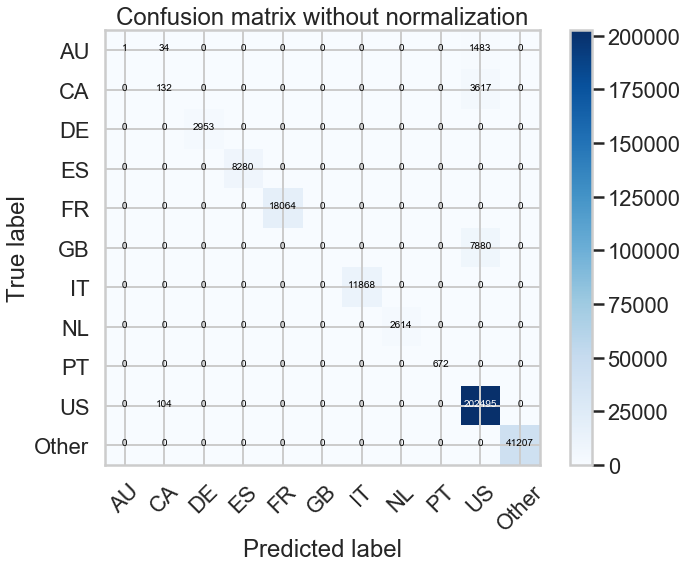

In [101]:
cnf_matrix = confusion_matrix(ytestlr, y_predict_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(11, 8))
plot_confusion_matrix(cnf_matrix, classes = ['AU', 'CA','DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US', 'Other'],
                      title='Confusion matrix without normalization')

In [108]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#print('\nAccuracy: {:.2f}\n'.format(accuracy_score(ytestlr, y_predict_test)))

#print('Micro Precision: {:.2f}'.format(precision_score(ytestlr, y_predict_test, average='micro')))
#print('Micro Recall: {:.2f}'.format(recall_score(ytestlr, y_predict_test, average='micro')))
#print('Micro F1-score: {:.2f}\n'.format(f1_score(ytestlr, y_predict_test, average='micro')))

#print('Macro Precision: {:.2f}'.format(precision_score(ytestlr, y_predict_test, average='macro')))
#print('Macro Recall: {:.2f}'.format(recall_score(ytestlr, y_predict_test, average='macro')))
#print('Macro F1-score: {:.2f}\n'.format(f1_score(ytestlr, y_predict_test, average='macro')))

#print('Weighted Precision: {:.2f}'.format(precision_score(ytestlr, y_predict_test, average='weighted')))
#print('Weighted Recall: {:.2f}'.format(recall_score(ytestlr, y_predict_test, average='weighted')))
#print('Weighted F1-score: {:.2f}'.format(f1_score(ytestlr, y_predict_test, average='weighted')))

In [107]:
#print(classification_report(ytestlr, y_predict_test))